In [27]:
import os
import torch
from PIL import Image
import pandas as pd
from tqdm import tqdm
from torchvision import transforms
import open_clip
import matplotlib.pyplot as plt

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")


Using device: mps


## EDA

In [16]:
import os
from collections import Counter
import matplotlib.pyplot as plt

data_dir = "data/EuroSAT_RGB"
class_dirs = sorted([
    d for d in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, d))
])

class_counts = {
    cls: len(os.listdir(os.path.join(data_dir, cls)))
    for cls in class_dirs
}


sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

for cls, count in sorted_counts:
    print(f"{cls:25s} : {count} images")

#Total 27000 images

AnnualCrop                : 3000 images
Forest                    : 3000 images
HerbaceousVegetation      : 3000 images
Residential               : 3000 images
SeaLake                   : 3000 images
Highway                   : 2500 images
Industrial                : 2500 images
PermanentCrop             : 2500 images
River                     : 2500 images
Pasture                   : 2000 images


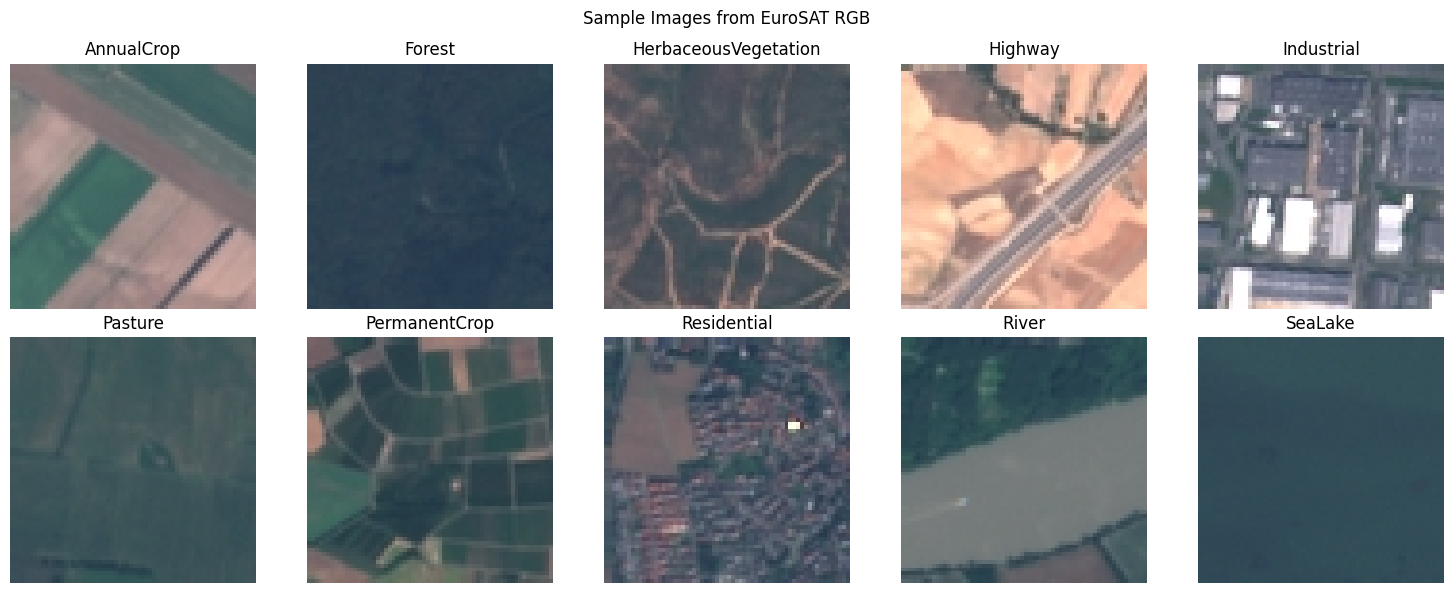

In [18]:
import matplotlib.pyplot as plt
from PIL import Image

ncols = 5
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 6))
fig.suptitle("Sample Images from EuroSAT RGB")

for i, cls in enumerate(class_dirs[:ncols * nrows]):
    img_dir = os.path.join(data_dir, cls)
    img_path = os.path.join(img_dir, os.listdir(img_dir)[0])  # first image
    img = Image.open(img_path)
    axs[i // ncols, i % ncols].imshow(img)
    axs[i // ncols, i % ncols].set_title(cls)
    axs[i // ncols, i % ncols].axis('off')

plt.tight_layout()
plt.show()


In [19]:
from PIL import Image
import numpy as np

sample_dims = []
for cls in class_dirs:
    img_path = os.path.join(data_dir, cls, os.listdir(os.path.join(data_dir, cls))[0])
    with Image.open(img_path) as img:
        sample_dims.append(img.size)

# Print shape info
print("Typical image shape (W x H):", sample_dims[0])


Typical image shape (W x H): (64, 64)


In [32]:
class_text = {
    "AnnualCrop": "agricultural land with seasonal crops",
    "Forest": "dense forest area",
    "HerbaceousVegetation": "wild grassy or herbaceous land",
    "Highway": "major road or highway",
    "Industrial": "industrial zone with factories",
    "Pasture": "open pasture land",
    "PermanentCrop": "orchard or vineyard with permanent crops",
    "Residential": "residential area with houses",
    "River": "river or stream body",
    "SeaLake": "large water body like sea or lake"
}


## Generate Metadata

In [36]:
import csv

# Mapping of class folder name to descriptive text
class_texts = {
    "AnnualCrop": "agricultural land with seasonal crops",
    "Forest": "dense forest area",
    "HerbaceousVegetation": "wild grassy or herbaceous land",
    "Highway": "major road or highway",
    "Industrial": "industrial zone with factories",
    "Pasture": "open pasture land",
    "PermanentCrop": "orchard or vineyard with permanent crops",
    "Residential": "residential area with houses",
    "River": "river or stream body",
    "SeaLake": "large water body like sea or lake"
}

data_dir = "data/EuroSAT_RGB"
metadata_path = os.path.join(data_dir, "metadata.csv")

with open(metadata_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["filename", "text"])

    for cls in class_text:
        cls_path = os.path.join(data_dir, cls)
        for fname in os.listdir(cls_path):
            if fname.endswith(".jpg"):
                fpath = os.path.join(cls, fname)  # relative path
                writer.writerow([fpath, class_text[cls]])

print(f"metadata.csv generated with text descriptions for {data_dir}")


metadata.csv generated with text descriptions for data/EuroSAT_RGB


## Load data

In [44]:
from torchvision import transforms
import open_clip
from torch.utils.data import DataLoader
from scripts.satellite_dataset import CLIPSatelliteDataset

# Set paths
metadata_csv = "data/EuroSAT_RGB/metadata.csv"
image_root = "data/EuroSAT_RGB"

# Load CLIP model and preprocessing
model, _, clip_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
tokenizer = open_clip.get_tokenizer('ViT-B-32')

# Choose subset size here:
SUBSET_SIZE = None #5000  # Change to None for full dataset

# Initialize dataset
dataset = CLIPSatelliteDataset(
    metadata_csv=metadata_csv,
    image_root=image_root,
    transform=clip_preprocess,
    tokenizer=tokenizer,
    max_samples=SUBSET_SIZE
)

# DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)


/Users/ctundia/Documents/Chintan/Projects/venvs/clip_satellite_env/lib/python3.13/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


## Training

In [45]:
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
import os

# Detect device
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Send model to device
model = model.to(device)
model.train()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Training loop
NUM_EPOCHS = 5

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    model.train()

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    for images, texts in loop:
        images, texts = images.to(device), texts.to(device)

        # Encode image and text
        image_features = model.encode_image(images)
        text_features = model.encode_text(texts)

        # Normalize
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)

        # Cosine similarity logits
        logits = image_features @ text_features.T

        # InfoNCE loss (symmetric)
        labels = torch.arange(len(images)).to(device)
        loss_i2t = F.cross_entropy(logits, labels)
        loss_t2i = F.cross_entropy(logits.T, labels)
        loss = (loss_i2t + loss_t2i) / 2

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} avg loss: {avg_loss:.4f}")


Using device: mps


Epoch 1/5: 100%|█████████████████| 1688/1688 [08:07<00:00,  3.46it/s, loss=1.48]


Epoch 1 avg loss: 2.1445


Epoch 2/5: 100%|█████████████████| 1688/1688 [13:47<00:00,  2.04it/s, loss=1.51]


Epoch 2 avg loss: 2.0619


Epoch 3/5: 100%|█████████████████| 1688/1688 [09:04<00:00,  3.10it/s, loss=1.35]


Epoch 3 avg loss: 2.0351


Epoch 4/5: 100%|█████████████████| 1688/1688 [08:31<00:00,  3.30it/s, loss=1.31]


Epoch 4 avg loss: 2.0121


Epoch 5/5: 100%|█████████████████| 1688/1688 [23:21<00:00,  1.20it/s, loss=1.46]

Epoch 5 avg loss: 1.9967


In [46]:
torch.save(model.state_dict(), f"models/clip_sat_epoch{epoch+1}_full.pt")

## Evaluation

In [47]:
top1_correct = 0
top5_correct = 0
total = 0

class_names = list(class_texts.keys())

with torch.no_grad():
    for images, text_tokens in tqdm(dataloader):
        images = images.to(device)

        image_features = model.encode_image(images)
        image_features = F.normalize(image_features, dim=-1)

        # Compute similarity (image x text)
        logits = image_features @ text_features.T  # [B, 10]

        # Get top-k predictions
        top1 = torch.argmax(logits, dim=1)
        top5 = torch.topk(logits, k=5, dim=1).indices

        # Get ground truth from tokenized text (reverse map)
        batch_labels = [class_names.index(dataset.df.iloc[i]["filename"].split("/")[0])
                        for i in range(total, total + len(images))]

        batch_labels = torch.tensor(batch_labels).to(device)

        top1_correct += (top1 == batch_labels).sum().item()
        top5_correct += sum([batch_labels[i] in top5[i] for i in range(len(images))])
        total += len(images)

# Print results
print(f"\nTop-1 Accuracy: {100 * top1_correct / total:.2f}%")
print(f"Top-5 Accuracy: {100 * top5_correct / total:.2f}%")


100%|███████████████████████████████████████| 1688/1688 [01:31<00:00, 18.38it/s]


Top-1 Accuracy: 10.88%
Top-5 Accuracy: 50.98%


In [48]:
import matplotlib.pyplot as plt

def show_predictions(model, dataset, text_features, class_names, text_descriptions, tokenizer, device, n=5):
    model.eval()
    indices = torch.randint(0, len(dataset), (n,))  # pick random samples

    fig, axs = plt.subplots(n, 1, figsize=(10, 3 * n))
    if n == 1: axs = [axs]

    for i, idx in enumerate(indices):
        idx = int(idx)  # convert tensor to int
        image, _ = dataset[idx]

    # for i, idx in enumerate(indices):
        # image, _ = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            img_feat = model.encode_image(image_tensor)
            img_feat = F.normalize(img_feat, dim=-1)
            logits = img_feat @ text_features.T  # (1, 10)

        scores = logits.squeeze().cpu().numpy()
        top5_idx = scores.argsort()[::-1][:5]

        gt_class = dataset.df.iloc[idx]["filename"].split("/")[0]
        gt_label = class_names.index(gt_class)

        # Plot
        axs[i].imshow(image.permute(1, 2, 0).cpu().numpy())
        axs[i].axis('off')
        axs[i].set_title(f"GT: {gt_class}", fontsize=14, color="green")

        # Predictions
        for rank, class_idx in enumerate(top5_idx):
            label = class_names[class_idx]
            score = scores[class_idx]
            correct = "✅" if class_idx == gt_label else "❌"
            axs[i].text(1.02, 0.9 - rank*0.12, f"{rank+1}. {label}: {score:.2f} {correct}",
                        transform=axs[i].transAxes, fontsize=12,
                        color="green" if class_idx == gt_label else "red")

    plt.tight_layout()
    plt.show()


/var/folders/ld/zxtt65194dz616j44fx98zh80000gn/T/ipykernel_31977/3909445840.py:43: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/ld/zxtt65194dz616j44fx98zh80000gn/T/ipykernel_31977/3909445840.py:43: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/ctundia/Documents/Chintan/Projects/venvs/clip_satellite_env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ctundia/Documents/Chintan/Projects/venvs/clip_satellite_env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


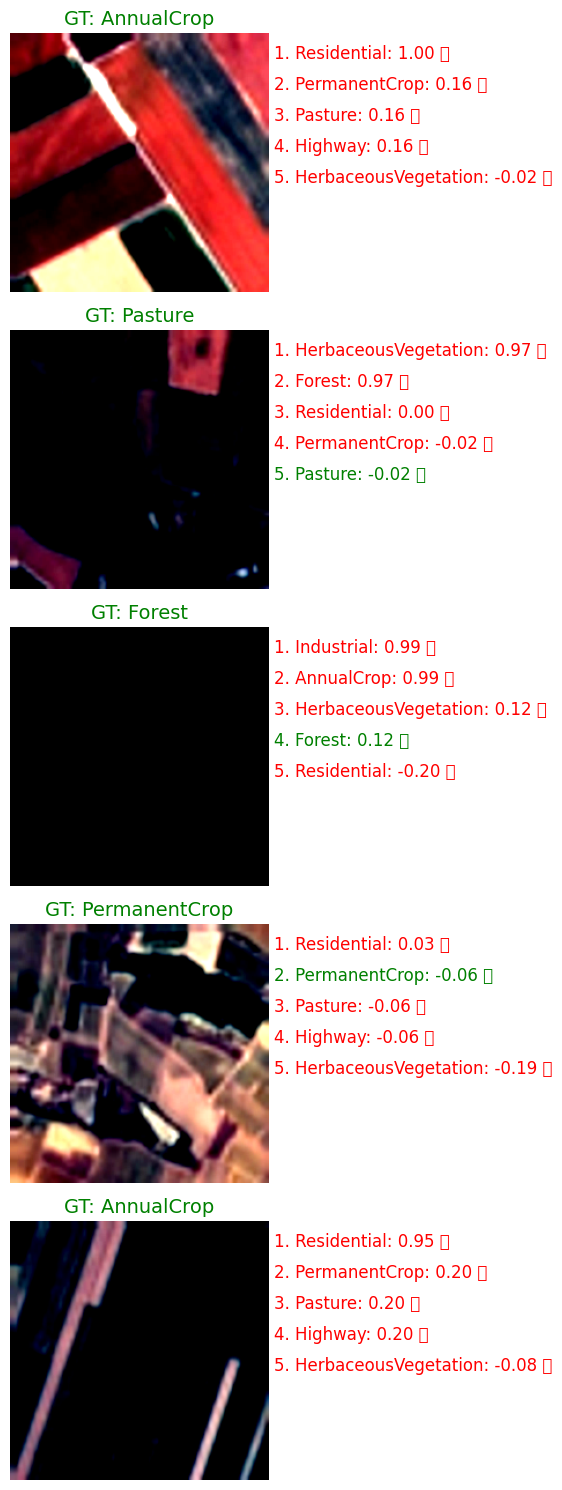

In [49]:
text_descriptions = list(class_texts.values())
show_predictions(
    model=model,
    dataset=dataset,
    text_features=text_features,
    class_names=class_names,
    text_descriptions=text_descriptions,
    tokenizer=tokenizer,
    device=device,
    n=5  # number of examples to visualize
)
